# Transfer learning with Xception
## Image Classification Coil-100


In [1]:
import os
import numpy as np # linear algebra
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Activation, GlobalAveragePooling2D, Conv2D, Flatten, Input
from tensorflow.keras import Model
import tensorflow as tf
#matplotlib.use('agg')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob,string
import codecs
from tqdm import tqdm

path = r'C:\Users\lesh3\Downloads\coil-100\coil-100\*.png'
files=glob.glob(path)


def contructDataframe(file_list):
    """
    this function builds a data frame which contains 
    the path to image and the tag/object name using the prefix of the image name
    """
    data=[]
    for file in tqdm(file_list):
        data.append((file,file.split("\\")[-1].split("__")[0][3:])
)
        
    return pd.DataFrame(data,columns=['path','label'])

frame=contructDataframe(files)


100%|██████████████████████████████████████████████████████████████████████████| 7200/7200 [00:00<00:00, 900494.66it/s]


# Data Processing

In [2]:
df=frame.sample(frac=1)
print("Labels number :" + str(len(df.label.value_counts())))


Labels number :100


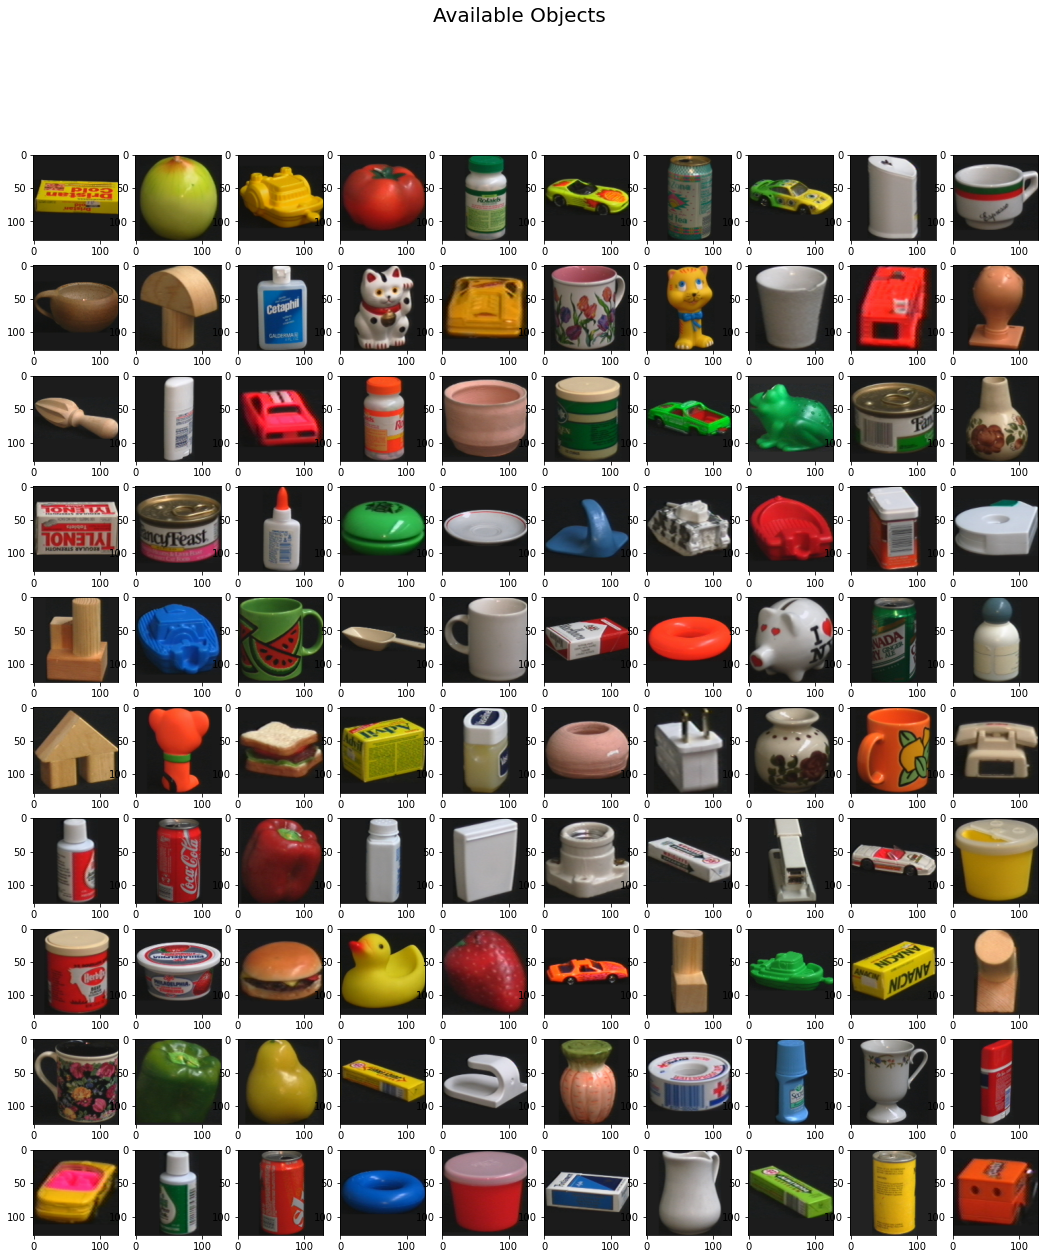

In [3]:
fig=plt.figure(figsize=(18, 20))
fig.suptitle('Available Objects', fontsize=20)
for unit in range(1,101):
    
    fig.add_subplot(10, 10, unit)
    im=plt.imread(df.loc[df['label']==str(unit)]['path'].iloc[0])
    plt.imshow(im)
    
plt.show()


In [4]:
print("Max/min label")
df.label= df.label.astype("int")-1
print(str(df['label'].max())+" / "+str(df['label'].min()))
print("Image shape :"+ str(im.shape))

Max/min label
99 / 0
Image shape :(128, 128, 3)


In [5]:
images= []
labels=[]
for i in df.iterrows():
    images.append(plt.imread(i[1]['path']))
    labels.append(i[1]['label'])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.20, random_state=42)

# Xception pre-trained CNN model

In [7]:
base_model=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)
base_model.trainable=False


In [8]:
f= GlobalAveragePooling2D()(base_model.output)
f= Dense(100, activation='softmax')(f)
model = Model(base_model.input, f)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(X_train)
history=model.fit(datagen.flow(np.asarray(X_train), np.asarray(y_train), batch_size=32),
steps_per_epoch=np.asarray(X_train).shape[0] / 32, epochs=20, validation_data=(np.asarray(X_test),np.asarray(y_test)))


Epoch 1/20
180/180 [==============================] - 201s 1s/step - loss: 1.0517 - accuracy: 0.7755 - val_loss: 0.2709 - val_accuracy: 0.9229
Epoch 2/20
180/180 [==============================] - 203s 1s/step - loss: 0.2080 - accuracy: 0.9616 - val_loss: 0.1161 - val_accuracy: 0.9826
Epoch 3/20
180/180 [==============================] - 206s 1s/step - loss: 0.1327 - accuracy: 0.9703 - val_loss: 0.1146 - val_accuracy: 0.9708
Epoch 4/20
180/180 [==============================] - 212s 1s/step - loss: 0.0971 - accuracy: 0.9780 - val_loss: 0.0785 - val_accuracy: 0.9750
Epoch 5/20
180/180 [==============================] - 220s 1s/step - loss: 0.0737 - accuracy: 0.9849 - val_loss: 0.0729 - val_accuracy: 0.9736
Epoch 6/20
180/180 [==============================] - 207s 1s/step - loss: 0.0652 - accuracy: 0.9856 - val_loss: 0.0529 - val_accuracy: 0.9847
Epoch 7/20
180/180 [==============================] - 205s 1s/step - loss: 0.0583 - accuracy: 0.9852 - val_loss: 0.0492 - val_accuracy: 0.9889

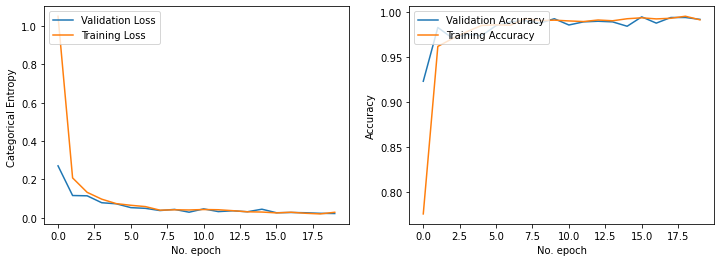

In [10]:
fig=plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.plot(history.history['loss'], label="Training Loss")

plt.ylabel('Categorical Entropy ')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

fig.add_subplot(1, 2, 2)

plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [11]:
model.evaluate(np.asarray(X_test),np.asarray(y_test))

45/45 [==============================] - 29s 641ms/step - loss: 0.0222 - accuracy: 0.9917


[0.02220059186220169, 0.9916666746139526]

In [13]:
from sklearn.metrics import classification_report
Y_pred = model.predict(np.array(X_test))
y_pred = np.argmax(Y_pred, axis=1)
report=pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report = report.iloc[:-3]
print("Classification report")
report.loc[report['f1-score']<1]

#recall is proportion of correctly recognized objects over the number of all recognised objects corresponding to a specific class ( TP/(TP+FP))
#precision is TP/(TP+FN) is a proportion of correctly recognized objects over a number of all available objects belonging to a specific class
    
    

Classification report


,precision,recall,f1-score,support
28,0.875000,1.000000,0.933333,14.0
31,1.000000,0.818182,0.900000,11.0
40,1.000000,0.947368,0.972973,19.0
41,1.000000,0.944444,0.971429,18.0
45,0.888889,1.000000,0.941176,16.0
50,0.916667,1.000000,0.956522,11.0
53,1.000000,0.823529,0.903226,17.0
60,0.850000,1.000000,0.918919,17.0
76,0.888889,1.000000,0.941176,16.0
77,0.956522,1.000000,0.977778,22.0


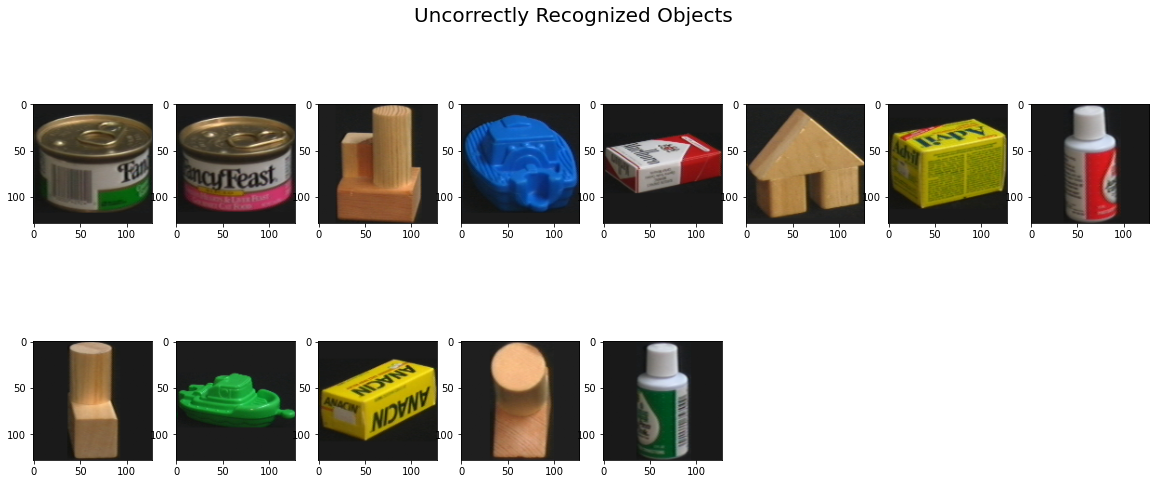

In [17]:
dUn=report.loc[report['f1-score']<1]
fig=plt.figure(figsize=(20, 8))
fig.suptitle('Uncorrectly Recognized Objects', fontsize=20)
for unit in range(1,dUn.shape[0]+1):
    fig.add_subplot(2, 8, unit)
    path=df.loc[df['label']==int(dUn.index[unit-1])].iloc[0]['path']
    im=plt.imread(path)
    plt.imshow(im)
plt.show()

# Xception for features extraction and ANN training

In [18]:
base_model=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
)
base_model.trainable=False

In [19]:
testFeatures= base_model.predict(np.asarray(X_test))
trainFeatures=base_model.predict(np.asarray(X_train))

In [20]:
inp= Input((4, 4, 2048))
f=Flatten()(inp)
f= Dense(800, activation='relu')(f)
f= Dense(500, activation='relu')(f)
f= Dense(300, activation='relu')(f) 
f=Dense(100, activation='softmax')(f)
model1 = Model(inp, f)
model1.summary()
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4, 4, 2048)]      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 800)               26215200  
_________________________________________________________________
dense_6 (Dense)              (None, 500)               400500    
_________________________________________________________________
dense_7 (Dense)              (None, 300)               150300    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               30100     
Total params: 26,796,100
Trainable params: 26,796,100
Non-trainable params: 0
__________________________________________

In [22]:
history1=model1.fit(np.asarray(trainFeatures), np.asarray(y_train),epochs=20,
                    validation_data=(np.asarray(testFeatures),np.asarray(y_test)))

Epoch 1/20
180/180 [==============================] - 21s 118ms/step - loss: 0.1489 - accuracy: 0.9622 - val_loss: 0.2859 - val_accuracy: 0.9528
Epoch 2/20
180/180 [==============================] - 21s 115ms/step - loss: 0.1374 - accuracy: 0.9719 - val_loss: 0.0929 - val_accuracy: 0.9736
Epoch 3/20
180/180 [==============================] - 21s 118ms/step - loss: 0.0552 - accuracy: 0.9905 - val_loss: 0.0644 - val_accuracy: 0.9799
Epoch 4/20
180/180 [==============================] - 22s 120ms/step - loss: 0.1712 - accuracy: 0.9653 - val_loss: 0.1087 - val_accuracy: 0.9729
Epoch 5/20
180/180 [==============================] - 21s 116ms/step - loss: 0.1418 - accuracy: 0.9736 - val_loss: 0.1645 - val_accuracy: 0.9701
Epoch 6/20
180/180 [==============================] - 21s 116ms/step - loss: 0.0899 - accuracy: 0.9809 - val_loss: 0.0414 - val_accuracy: 0.9896
Epoch 7/20
180/180 [==============================] - 21s 116ms/step - loss: 0.0320 - accuracy: 0.9944 - val_loss: 0.0117 - val_ac

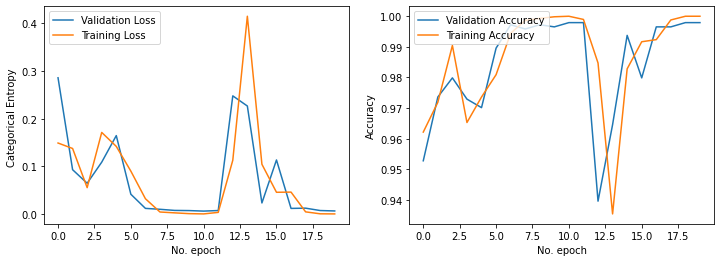

In [23]:
fig=plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(history1.history['val_loss'], label="Validation Loss")
plt.plot(history1.history['loss'], label="Training Loss")

plt.ylabel('Categorical Entropy ')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

fig.add_subplot(1, 2, 2)

plt.plot(history1.history['val_accuracy'], label="Validation Accuracy")
plt.plot(history1.history['accuracy'], label="Training Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [30]:
model1.evaluate(np.asarray(testFeatures), np.asarray(y_test))

45/45 [==============================] - 1s 13ms/step - loss: 0.0063 - accuracy: 0.9979


[0.00630177790299058, 0.9979166388511658]

In [26]:
Y_pred = model1.predict(np.asarray(testFeatures))
y_pred = np.argmax(Y_pred, axis=1)
report=pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report = report.iloc[:-3]
print("Classification report")
report.loc[report['f1-score']<1]

Classification report


,precision,recall,f1-score,support
18,1.000000,0.947368,0.972973,19.0
28,0.933333,1.000000,0.965517,14.0
31,1.000000,0.909091,0.952381,11.0
56,0.909091,1.000000,0.952381,10.0
67,1.000000,0.941176,0.969697,17.0
83,0.916667,1.000000,0.956522,11.0


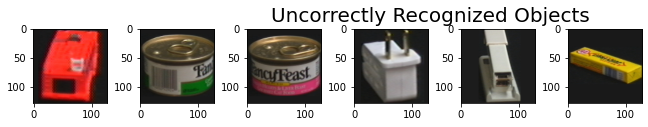

In [28]:
dUn=report.loc[report['f1-score']<1]
fig=plt.figure(figsize=(15, 3))
fig.suptitle('Uncorrectly Recognized Objects', fontsize=20)
for unit in range(1,dUn.shape[0]+1):
    fig.add_subplot(2, 8, unit)
    path=df.loc[df['label']==int(dUn.index[unit-1])].iloc[0]['path']
    im=plt.imread(path)
    plt.imshow(im)
plt.show()